In [1]:
from os import path
if not path.exists("COVID-19"):
    !git clone https://github.com/CSSEGISandData/COVID-19.git
else:
    !git --work-tree=COVID-19 --git-dir=COVID-19/.git pull origin master

remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Total 16 (delta 12), reused 12 (delta 12), pack-reused 4
Unpacking objects: 100% (16/16), done.
From https://github.com/CSSEGISandData/COVID-19
 * branch              master     -> FETCH_HEAD
   4fd1f718..05622493  master     -> origin/master
Updating 4fd1f718..05622493
Fast-forward
 .../csse_covid_19_daily_reports/04-29-2020.csv     | 3169 ++++++++++
 .../csse_covid_19_daily_reports_us/04-29-2020.csv  |   60 +
 .../time_series_covid19_confirmed_US.csv           | 6526 ++++++++++----------
 .../time_series_covid19_confirmed_global.csv       |  530 +-
 .../time_series_covid19_deaths_US.csv              | 6526 ++++++++++----------
 .../time_series_covid19_deaths_global.csv          |  530 +-
 .../time_series_covid19_recovered_global.csv       |  502 +-
 7 files changed, 10536 insertions(+), 7307 deletions(-)
 create mode 100644 csse_covid_19_data/csse_covid_19_daily_reports/04-29-2020.csv
 create

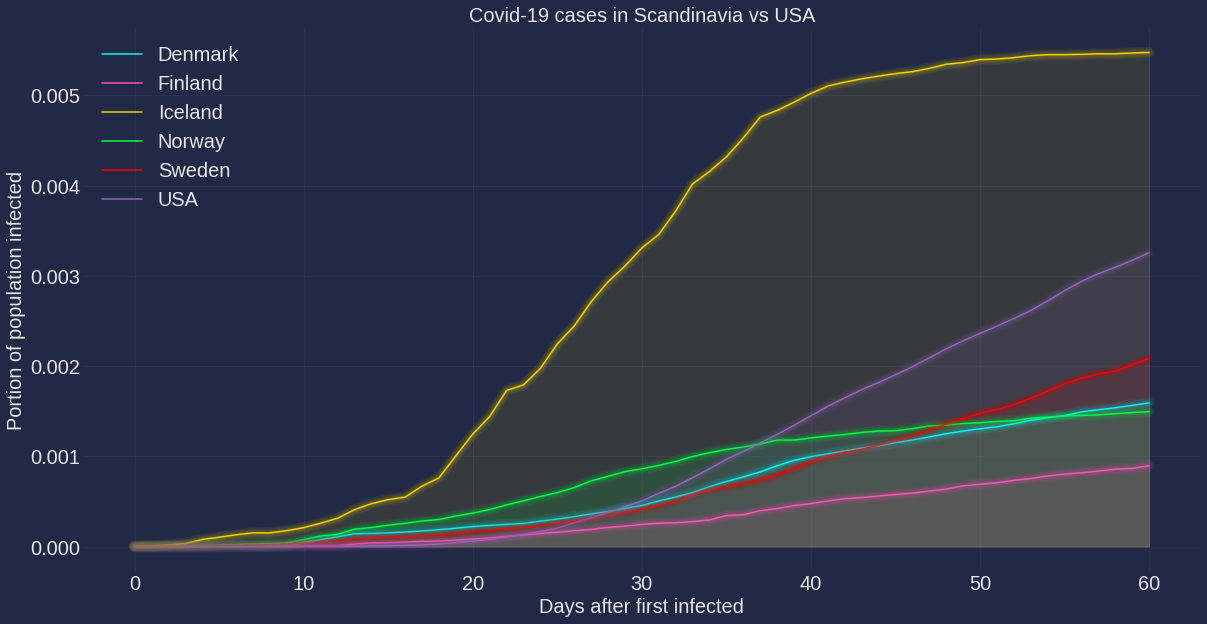

In [4]:
import pandas as pd
import numpy as np
import countryinfo as ci
import pystan
import matplotlib.pyplot as plt
import mplcyberpunk
import pickle
import arviz as az

%matplotlib inline

plt.style.use("cyberpunk")

countries = ["Denmark", "Finland", "Iceland", "Norway", "Sweden"] # contries analyzed 

data = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
data = data.loc[data['Country/Region'].isin(countries)]
data = data[2:].reset_index()
data = data.drop(columns=['index', 'Province/State', 'Lat', 'Long'])

# Normalize data by population
data_normalized = data.apply(lambda row: pd.to_numeric(row[1:]) / ci.CountryInfo(row[0]).population(), axis=1)
data_normalized.insert(0, "Country", data.head()["Country/Region"]) 
data_normalized.set_index('Country', inplace=True)

# Get US data
data_us = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
data_us = data_us.drop(columns=['UID','iso2','iso3','code3', 'FIPS', 'Combined_Key', 'Admin2', 'Province_State', 'Lat', 'Long_'])
data_us = data_us[1:].sum().to_frame()
data_us = data_us[1:].T
data_us_n = data_us.apply(lambda row: pd.to_numeric(row[1:]) / ci.CountryInfo('United States').population(),axis=1)
d_us = np.array(data_us_n)[:,37:]
d = np.array(data_normalized)[:,38:]

d = np.concatenate((d,d_us),0)

countries.append('USA')

plt.figure(figsize=(20,10))
for idx, c in enumerate(countries):
    plt.plot(np.arange(d.shape[1]),d[idx,:], label = c)

    
plt.legend(fontsize=20)
plt.xlabel('Days after first infected',fontsize=20)
plt.ylabel('Portion of population infected',fontsize=20)
plt.title('Covid-19 cases in Scandinavia vs USA',fontsize=20)
plt.tick_params(axis='both',labelsize=20)
mplcyberpunk.add_glow_effects()
plt.show()

In [5]:
model_h = """
data {
  int<lower=0> T; // number of time steps (days)
  int<lower=0> T_future;// number of steps to predict into the future (days)
  int<lower=0> n_countries; // number of countries
  real<lower=0, upper=1> z[T,n_countries]; // percentage of population infected 
}

parameters {
   real mu_t0;
   real<lower=0> tau_t0;
   real mu_k;
   real<lower=0> tau_k;
   real mu_L;
   real<lower=0> tau_L;

  real<lower=0> t0[n_countries]; 
  real<lower=0> k[n_countries];
  real<lower=0, upper=1> L[n_countries];
  real<lower=0> sigma;

}
transformed parameters {
   real m[T,n_countries];

   for (t in 1:T) {
     for (n in 1:n_countries) {
       m[t,n] = L[n] / (1+exp(-k[n]*(t-t0[n])));
       }
    }
}
model {
// define model using uniform uninformative priors 
  mu_L ~ normal(0.7, 0.05);
    
  t0 ~ normal(mu_t0, tau_t0);
  k ~ normal(mu_k, tau_k);
  L ~ normal(mu_L, tau_L);
  
  for (t in 1:T) {
    for (n in 1:n_countries) {
      z[t,n] ~ normal(m[t,n], sigma);
    }
  }
  
}

generated quantities{
// generate predictions for comparison between data and prediction
  real z_pred[T+T_future,n_countries];
  vector[T*n_countries] log_lik;
  for (t in 1:T+T_future) {
    for(n in 1:n_countries){
      z_pred[t,n] = normal_rng(L[n] / (1+exp(-k[n]*(t-t0[n]))),sigma);
    }
  }
  
    for (t in 1:T)
        for (n in 1:n_countries)
            log_lik[n+((t-1)*n_countries)] = normal_lpdf(z[t,n] | L[n] / (1+exp(-k[n]*(t-t0[n]))),sigma);

}

"""

In [6]:
model_p = """
data {
  int<lower=0> T; // number of time steps (days)
  int<lower=0> T_future;// number of steps to predict into the future (days)
  int<lower=0> n_countries; // number of countries
  real<lower=0, upper=1> z[T,n_countries]; // percentage of population infected 
}

parameters {
  real<lower=0> t0; 
  real<lower=0> k;
  real<lower=0, upper=1> L;
  real<lower=0> sigma;

}
transformed parameters {
   real m[T,n_countries];
   for (t in 1:T) {
     for (n in 1:n_countries) {
       m[t,n] = L / (1+exp(-k*(t-t0)));
       }
    }
}
model {
// define model using uniform uninformative priors 
  L ~ normal(0.7, 0.05);
  for (t in 1:T) {
    for (n in 1:n_countries) {
      z[t,n] ~ normal(m[t,n], sigma);
    }
  }
  
}

generated quantities{
// generate predictions for comparison between data and prediction
  real z_pred[T+T_future,n_countries];
  vector[T*n_countries] log_lik;
  
  for (t in 1:T+T_future) {
    for(n in 1:n_countries){
      z_pred[t,n] = normal_rng(L / (1+exp(-k*(t-t0))),sigma);
    }
  }
   for (t in 1:T)
        for (n in 1:n_countries)
            log_lik[n+((t-1)*n_countries)] = normal_lpdf(z[t,n] | L / (1+exp(-k*(t-t0))),sigma);
}

"""

In [7]:
model_s = """
data {
  int<lower=0> T; // number of time steps (days)
  int<lower=0> T_future;// number of steps to predict into the future (days)
  int<lower=0> n_countries; // number of countries
  real<lower=0, upper=1> z[T,n_countries]; // percentage of population infected 
}

parameters {
  real<lower=0> t0[n_countries]; 
  real<lower=0> k[n_countries];
  real<lower=0, upper=1> L[n_countries];
  real<lower=0> sigma[n_countries];

}
transformed parameters {
   real m[T,n_countries];
   for (t in 1:T) {
     for (n in 1:n_countries) {
       m[t,n] = L[n] / (1+exp(-k[n]*(t-t0[n])));
       }
    }
}
model {
// define model using uniform uninformative priors 
  for (t in 1:T) {
    for (n in 1:n_countries) {
      z[t,n] ~ normal(m[t,n], sigma[n]);
    }
  }
  
}

generated quantities{
// generate predictions for comparison between data and prediction
  real z_pred[T+T_future,n_countries];
  vector[T*n_countries] log_lik;
  
  for (t in 1:T+T_future) {
    for(n in 1:n_countries){
      z_pred[t,n] = normal_rng(L[n] / (1+exp(-k[n]*(t-t0[n]))),sigma[n]);
    }
  }
  for (t in 1:T)
        for (n in 1:n_countries)
            log_lik[n+((t-1)*n_countries)] = normal_lpdf(z[t,n] | L[n] / (1+exp(-k[n]*(t-t0[n]))),sigma[n]);
}

"""

In [ ]:
T = d.shape[1]
n_countries = d.shape[0]
z = d.T
y0 = np.zeros(d.shape[0])

stan_data = {'T': T, 'n_countries': n_countries, 'z': z, 'T_future': 50}

sm = pystan.StanModel(model_code=model_s)
fit_s = sm.sampling(data=stan_data, warmup = 500, iter=2500, chains=4)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d58139aa18b0d4144a5ba8d812eb35be NOW.


In [ ]:
T = d.shape[1]
n_countries = d.shape[0]
z = d.T
y0 = np.zeros(d.shape[0])

stan_data = {'T': T, 'n_countries': n_countries, 'z': z, 'T_future': 50}

sm = pystan.StanModel(model_code=model_p)
fit_p = sm.sampling(data=stan_data, warmup = 500, iter=2500, chains=4)

In [ ]:
T = d.shape[1]
n_countries = d.shape[0]
z = d.T
y0 = np.zeros(d.shape[0])

stan_data = {'T': T, 'n_countries': n_countries, 'z': z, 'T_future': 50}

sm = pystan.StanModel(model_code=model_h)
fit_h = sm.sampling(data=stan_data, warmup = 500, iter=2500, chains=4)

In [ ]:
def plot_f(f):
    fig, ax = plt.subplots(4, 1, figsize=(9, 16),sharey=True, gridspec_kw={'hspace': 0.5})
    
    for i, a in enumerate(ax.flat):
        plt.sca(a)
        plt.plot(np.mean(f['z_pred'][:,:,i],0), label = countries[i])
        az.plot_hpd(np.arange(f['z_pred'].shape[1]),np.expand_dims(f['z_pred'],0)[:,:,:,i])
        plt.plot(np.array(d)[i])
        #plt.legend(fontsize=20)
        mplcyberpunk.make_lines_glow()
        a.title.set_text(countries[i])
        
    fig.tight_layout()
    plt.show()

def plot_(f, gray=False, font = 26):
    fig = plt.figure(figsize=(20, 10))
    colors = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41',  # matrix green
    'r',        # ..... red 
    ]
    
    for i in range(f['z_pred'].shape[2]):
        if not gray:
            plt.plot(np.mean(f['z_pred'][:,:,i],0), color = colors[i], linestyle='--')
            az.plot_hpd(np.arange(f['z_pred'].shape[1]),np.expand_dims(f['z_pred'],0)[:,:,:,i], fill_kwargs={'alpha': 0.2}, color=colors[i])
        plt.plot(np.array(d)[i], color = colors[i],  label = countries[i])
    if gray:
        plt.plot(np.mean(f['z_pred'][:,:,i],0), color = 'gray', linestyle='--')
        az.plot_hpd(np.arange(f['z_pred'].shape[1]),np.expand_dims(f['z_pred'],0)[:,:,:,i], fill_kwargs={'alpha': 0.2}, color = 'gray')
    plt.legend(fontsize=font) 
    mplcyberpunk.make_lines_glow(n_glow_lines=3, diff_linewidth=1.02, alpha_line=0.2)
    plt.xlabel('Days after first infected',fontsize=font)
    plt.ylabel('Portion of population infected',fontsize=font)
    plt.title('Predicted Covid-19 cases in Scandinavia',fontsize=font)
    #plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.tick_params(axis='both',labelsize=20)
    fig.tight_layout()
    plt.show()
    

In [ ]:
f = fit_h.extract()
plot_(f)

In [ ]:
f = fit_s.extract()
plot_(f)

In [ ]:
f = fit_p.extract()
plot_(f,1)

In [ ]:
az_h = az.from_pystan(fit_h, log_likelihood="log_lik")
az_s = az.from_pystan(fit_s, log_likelihood="log_lik")
az_p = az.from_pystan(fit_p, log_likelihood="log_lik")
print(az.loo(az_h,pointwise=True))
print(az.loo(az_s,pointwise=True))
print(az.loo(az_p,pointwise=True))

In [ ]:
idata = {
    'hierarchical' : az_h,
    'separate' : az_s,
    'pooled' : az_p
    }
print(az.compare(idata))

In [ ]:
# Find index for when 2 persons are smittet
data.insert(0, "Country", data.head()["Country/Region"]) 
data.set_index('Country', inplace=True)
df = data
#for c in countries:
    #print(df.loc[c][1:].astype(int).gt(2).argmax())

print(data_us.loc[0][38:])

In [16]:
data = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
data = data.drop(columns=['UID','iso2','iso3','code3', 'FIPS', 'Combined_Key', 'Admin2', 'Province_State', 'Lat', 'Long_'])
data = data[1:].sum().to_frame()
data = data[1:].T
data = data.apply(lambda row: pd.to_numeric(row[1:]) / ci.CountryInfo('United States').population(),axis=1)


In [18]:
print(fit_h)

Inference for Stan model: anon_model_8e4ed7a1af1a68292934af2945d3a0ea.
4 chains, each with iter=2500; warmup=500; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

                 mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
mu_t0           39.68    0.11    5.55   28.02   37.04   39.77   42.49   50.71   2731    1.0
tau_t0           11.1    0.14    7.25    4.58    6.93    9.11   12.63   29.89   2873    1.0
mu_k             0.12  3.2e-4    0.01    0.09    0.11    0.12    0.13    0.15   2031    1.0
tau_k            0.03  4.4e-4    0.02    0.01    0.02    0.02    0.03    0.07   1972    1.0
mu_L             0.69  5.0e-4    0.05    0.58    0.65    0.69    0.72    0.79  10310    1.0
tau_L            0.96  7.4e-3    0.51    0.45    0.66    0.84    1.11    2.25   4838    1.0
t0[1]           38.38  6.4e-3    0.44   37.55   38.07   38.37   38.67   39.29   4808    1.0
t0[2]           41.67    0.02    1.04   39.76   40.94   41.61   42.33   43.9